# Figure 2: Time until vote

In [1]:
source('../scripts/load_libraries.R')
source('../scripts/load_constants.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




In [2]:
source('../scripts/load_data.R')

Rows: 17264341 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): comment_id, user_id, author_id, anonymous, first_view

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1281001 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, score, time_stamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 223737 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, num, time_stamp

ℹ Use `spec()` t

In [3]:
voting <- df_clean %>%
  filter(up + dn > 0) %>%
  inner_join(votes %>% select(comment_id, user_id, vote_time = time_stamp)) %>%
  mutate(ttv = vote_time - first_view)

Joining, by = c("comment_id", "user_id")


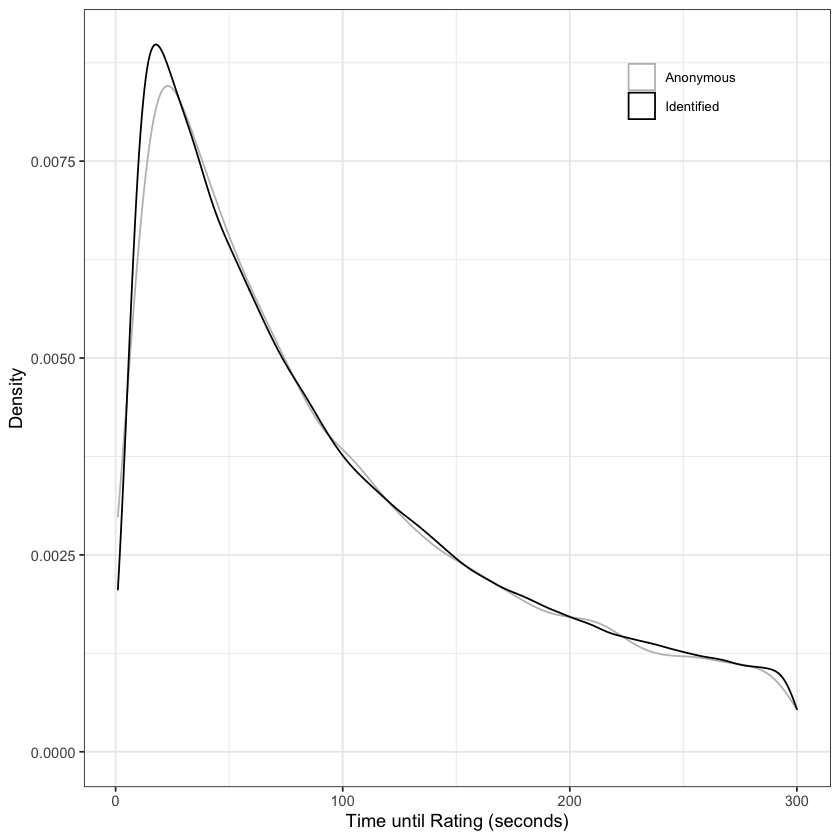

In [4]:
p1 <- voting %>%
  filter(ttv <= 300) %>%
  mutate(Condition = if_else(anonymous == 1, 'Anonymous', 'Identified')) %>%
  ggplot(aes(x = ttv, colour = Condition, group = Condition)) +
  geom_density() +
  scale_color_manual(values = c('grey', 'black')) +
  xlab('Time until Rating (seconds)') +
  ylab('Density') +
  theme_bw() +
  theme(legend.position = c(0.8, 0.9),
        legend.title=element_blank(),
        legend.text=element_text(size=8),
        legend.background = element_blank())
  
p1

In [5]:
ggsave('../figures/fig-2a.pdf', p1, width = 3.5, height = 3)

In [6]:
regs <- tibble(ttv = seq(1,15, by = 1)) %>%
  group_by(ttv) %>% do({
    A <- first(.$ttv)
    m <- felm(I(ttv >= A) ~ identified | user_id | 0 | user_id,
              data = voting)
    broom::tidy(m)
  })

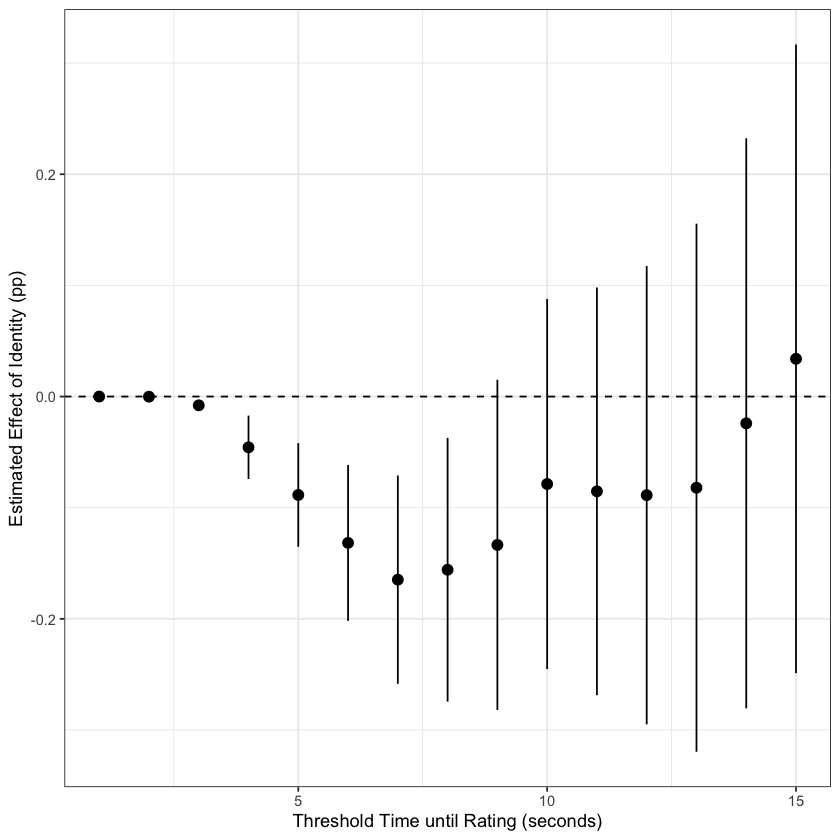

In [7]:
p2 <- regs %>%
  filter(term == 'identified') %>%
  mutate(estimate = 100 * estimate,
         std.error = 100 * std.error) %>%
  ggplot(aes(x = ttv, y = estimate,
             ymin = estimate - 1.96 * std.error,
             ymax = estimate + 1.96 * std.error)) +
  geom_pointrange() +
  xlab('Threshold Time until Rating (seconds)') +
  ylab('Estimated Effect of Identity (pp)') +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  scale_x_continuous(breaks = c(0,5,10,15)) +
  theme_bw()
p2

In [8]:
ggsave('../figures/fig-2b.pdf', p2, width = 3.5, height = 3)